Creating ReplayPhenotype and Fitness objects

In [1]:
from gcdyn.fitness import Fitness
from gcdyn.replay import ReplayPhenotype
import gcdyn.replay as replay

replay_phenotype = ReplayPhenotype(
            1,
            1,
            336,
            "https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv",
            "Linear.model",
            ["delta_log10_KD", "expression"],
            -10.43,
        )


fasta_path = "gcreplay_samples/gctree_PR1.3-1-LB-16-GC.fasta"
seqs = replay.fasta_to_seq_list(fasta_path)

seq_df = replay_phenotype.calculate_KD_df(seqs)
fit = Fitness("sigmoid")
fitness_df = fit.fitness_df(seqs, KD_calculator=replay_phenotype.return_KD)

Testing different antigen concentrations vs antigen bound

/Users/alyssa/miniconda3/envs/gcdyn_39/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/alyssa/miniconda3/envs/gcdyn_39/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 10 rows containing missing values.


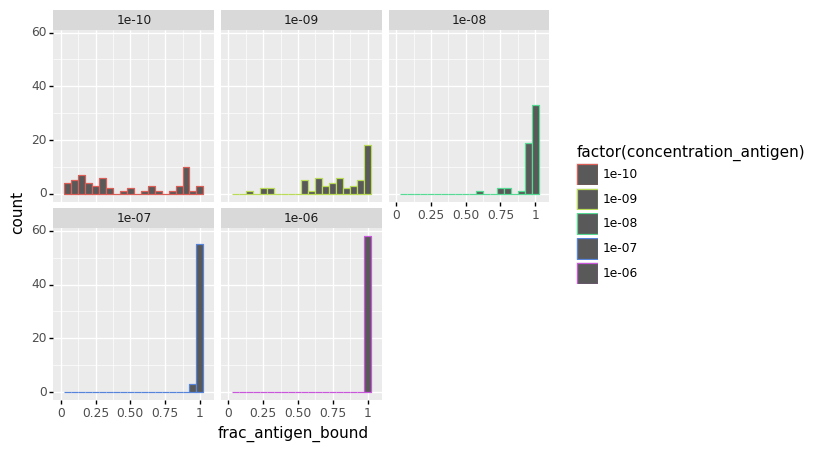

<ggplot: (8766526732057)>

In [2]:
import pandas as pd
from plotnine import ggplot, geom_histogram, aes, facet_wrap, ggtitle, xlim, ylim

antigen_bound_fracs = []
concentrations = []
for c in range(6,11): # concentration of antigen from 10^-6 to 10^-10
    concentration_antigen = 10**(-1*c)
    fit = Fitness(concentration_antigen=concentration_antigen)
    antigen_bound_fracs.extend(fit.frac_antigen_bound(fitness_df["KD"]))
    concentrations.extend([concentration_antigen]*len(fitness_df["KD"]))

antigen_bound_df = pd.DataFrame({"concentration_antigen": concentrations, "frac_antigen_bound": antigen_bound_fracs})
antigen_bound_df

ggplot(antigen_bound_df) + facet_wrap(facets="~concentration_antigen") + aes(x="frac_antigen_bound", color='factor(concentration_antigen)') + geom_histogram(binwidth=0.05) + xlim(0,1.05)

Mapping to fitness (sigmoidal)

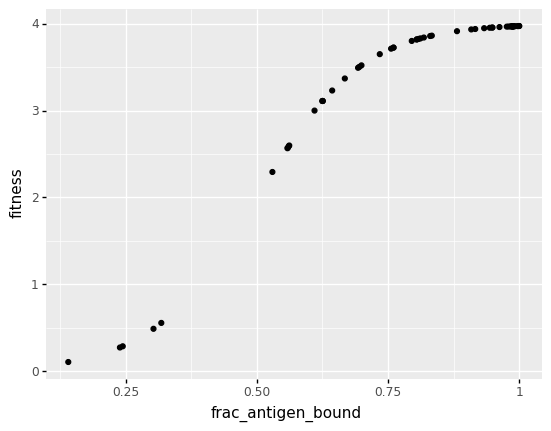

<ggplot: (8766527201268)>

In [3]:
from plotnine import geom_point
from math import exp

ggplot(fitness_df) + aes(x="frac_antigen_bound", y = "fitness") + geom_point()

Normalizing fitness

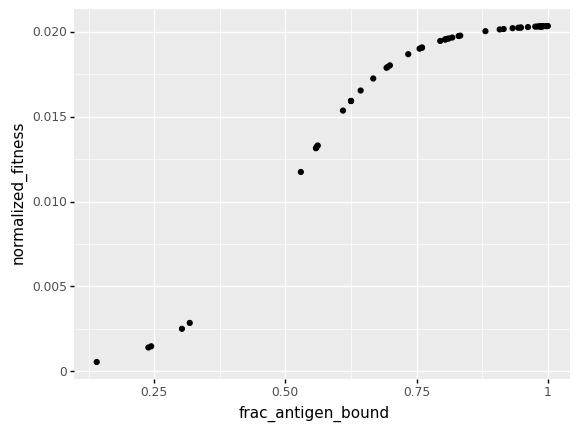

<ggplot: (8766527255742)>

In [4]:
fit.normalize_fitness(fitness_df)
ggplot(fitness_df) + aes(x="frac_antigen_bound", y = "normalized_fitness") + geom_point()

Map to fitness (linear)

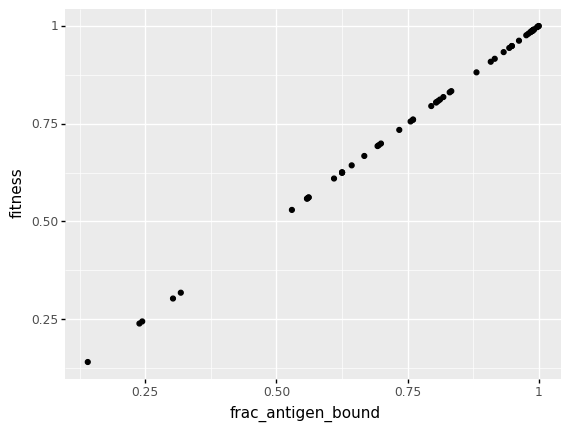

<ggplot: (8766527356413)>

In [5]:
linfit = Fitness("linear")
linfit_fitness_df = linfit.fitness_df(seqs, KD_calculator=replay_phenotype.return_KD)
ggplot(linfit_fitness_df) + aes(x="frac_antigen_bound", y = "fitness") + geom_point()

In [36]:
# map normalized fitness linearly to number of cell divisions
linfit.normalize_fitness(linfit_fitness_df)
test_cell_divs = linfit.map_cell_divisions(linfit_fitness_df, 200)

In [38]:
from ete3 import TreeNode

# just a basic test for building subtrees using cell_divisions, not actual proliferator
def cell_div_proliferator(treenode: TreeNode, cell_divisions: float):
    if(cell_divisions > 0): 
        for _ in range(2):
            child = TreeNode()
            child.dist = 1/(cell_divisions)
            child.sequence = treenode.sequence
            child.terminated = False
            treenode.add_child(child)
            cell_div_proliferator(child, cell_divisions - 1)
                
for div_val in test_cell_divs[:5]:
    test_tree = TreeNode(dist=0)
    test_tree.sequence = "GGGG"
    cell_div_proliferator(test_tree, div_val)
    print(test_tree)    
    


               /-
            /-|
           |   \-
         /-|
        |  |   /-
        |   \-|
        |      \-
      /-|
     |  |      /-
     |  |   /-|
     |  |  |   \-
     |   \-|
     |     |   /-
     |      \-|
     |         \-
   /-|
  |  |         /-
  |  |      /-|
  |  |     |   \-
  |  |   /-|
  |  |  |  |   /-
  |  |  |   \-|
  |  |  |      \-
  |   \-|
  |     |      /-
  |     |   /-|
  |     |  |   \-
  |      \-|
  |        |   /-
  |         \-|
  |            \-
--|
  |            /-
  |         /-|
  |        |   \-
  |      /-|
  |     |  |   /-
  |     |   \-|
  |     |      \-
  |   /-|
  |  |  |      /-
  |  |  |   /-|
  |  |  |  |   \-
  |  |   \-|
  |  |     |   /-
  |  |      \-|
  |  |         \-
   \-|
     |         /-
     |      /-|
     |     |   \-
     |   /-|
     |  |  |   /-
     |  |   \-|
     |  |      \-
      \-|
        |      /-
        |   /-|
        |  |   \-
         \-|
           |   /-
            \-|
               \-

    